In [6]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

# animations, etc. requires below magic command
# %matplotlib notebook


"""
Load relevant packages
"""

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

import seaborn as sns

#import autograd
# functions to approx derivative and hessian
from statsmodels.tools.numdiff import approx_fprime, approx_hess


from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.moments import calculate_cov_mat,  calculate_cov_mat_factor, calculate_outer_product

import codelib.statistics.historical_probabilities as hp

from codelib.portfolio_optimization.risk_budget import calculate_risk_contributions_std

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

from codelib.visualization.base import waterfall_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimation and Estimation Uncertainty

## OLS 

### OLS Example

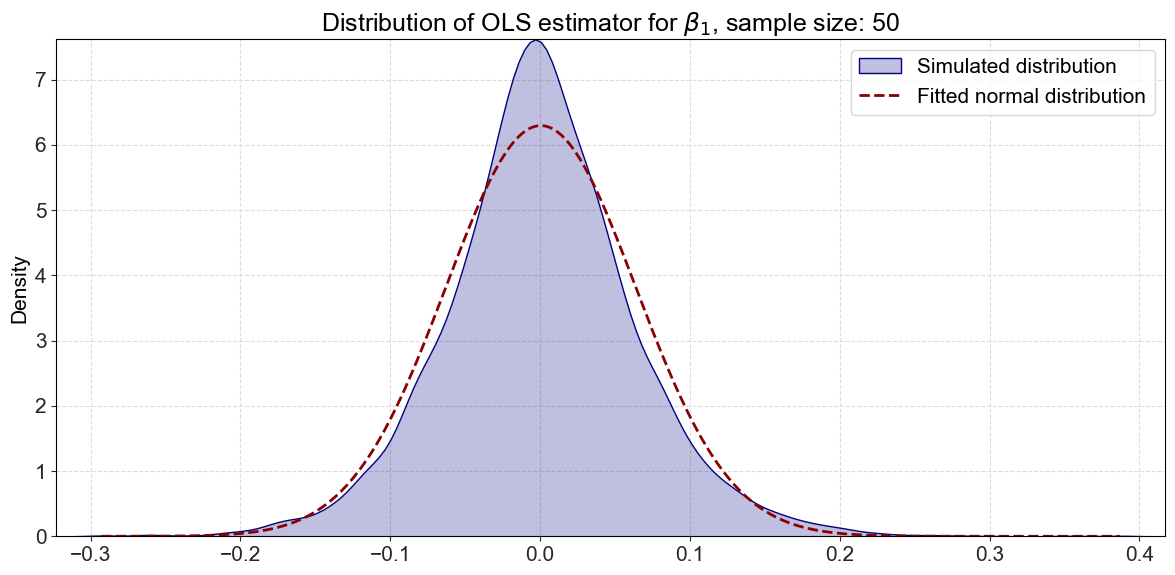

In [3]:
"""
Settings
"""

# number of simulations
num_sim = 10000

# sample size 
sample_size = 50

# true parameter values: constant, beta1, beta2
beta0 = np.array([1.0, 1.0, 1.0])

"""
Simulations
"""

all_beta_est = np.empty((num_sim, len(beta0)))
for i in range(num_sim): 
    
    # generate independent variables
    x1_sim = stats.lognorm.rvs(1, scale=1, size=sample_size) 
    x2_sim = stats.lognorm.rvs(1, scale=1, size=sample_size)
    x_mat_sim = np.vstack([np.ones(sample_size), x1_sim, x2_sim]).T

    # simulate error term
    eps_sim = stats.lognorm.rvs(0.1, loc=-np.exp(0.1**2 / 0.5), scale=1, size=sample_size) # s: sigma, scale: exp(mu), loc: exp(mu + sigma^2 / 2)

    # simulate dependent variable
    y_sim = x_mat_sim @ beta0 + eps_sim
    
    # estimate parameters
    beta_est, res, _, _ = np.linalg.lstsq(x_mat_sim, y_sim, rcond=-1)
    
    all_beta_est[i, :] = beta_est

"""
Plotting
"""
    
idx = 1 # 0: constant, 1: beta1, 2: beta2
param_name_dict = {0: '$\\alpha$', 1: '$\\beta_1$', 2: '$\\beta_2$'}
diff = (all_beta_est[:, idx] - beta0[idx]) * np.sqrt(sample_size)

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(diff, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution")

norm_params = stats.norm.fit(diff)

vals_to_eval = np.linspace(min(diff), max(diff), 1000)
ax.plot(vals_to_eval, stats.norm(norm_params[0], norm_params[1]).pdf(vals_to_eval), color="darkred", linestyle="--",
        label="Fitted normal distribution")

ax.set(title="Distribution of OLS estimator for " + param_name_dict[idx] + ", sample size: {}".format(sample_size))

ax.legend();

plt.tight_layout()
plt.savefig("Distribution of OLS estimator for " + "beta1" + ", sample size is {}.pdf".format(sample_size))

In [4]:
"Distribution of OLS estimator for " + "beta1" + ", sample size: {}.pdf".format(sample_size)

'Distribution of OLS estimator for beta1, sample size: 50.pdf'

## Shrinkage covariance matrix

In [7]:
def marchencko_pastur_bounds(sigma: float, ratio: float) -> Tuple[float, float]:

    """
    Calculates Marcencko-Pastur bounds

    Parameters
    ----------
    sigma:
        Sigma parameter.
    ratio:
        Ratio between num. of variables and num. of observations

    Returns
    -------
    Tuple[float, float]
        Bounds.

    """

    sigma2 = sigma ** 2

    lower = sigma2 * (1 - np.sqrt(ratio)) ** 2
    upper = sigma2 * (1 + np.sqrt(ratio)) ** 2

    bounds = (lower, upper)

    return bounds


def marchencko_pastur_density(x: np.ndarray, sigma: float, ratio: float) -> np.ndarray:

    """
    Calculates Marcencko-Pastur density

    Parameters
    ----------
    x:
        Points at which to evaluate the density.
    sigma:
       Sigma parameter.
    ratio:
       Ratio between num. of variables and num. of observations

    Returns
    -------
    np.ndarray
       Densitiy.

    """

    lower, upper = marchencko_pastur_bounds(sigma, ratio)

    indicator = np.int64(x >= lower) * np.int64(x <= upper)
    dv = np.zeros(indicator.shape)

    for i in range(len(x)):
        temp = x[i]
        idx = indicator[i]
        if idx:
            dv[i] = 1.0 / (2.0 * np.pi * sigma ** 2) * np.sqrt((upper - temp) * (temp - lower)) / (ratio * temp)

    return dv


In [8]:
n = 1000
t = 1500

mu = np.zeros(n)
cov = np.eye(n)

simulated_data = np.random.multivariate_normal(mu, cov, size=t)

"""
All the true eigenvalues are equal to one!
"""

# the first 10 eigenvalues
true_eigenvalues = np.linalg.eig(cov)
true_eigenvalues[0][0:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

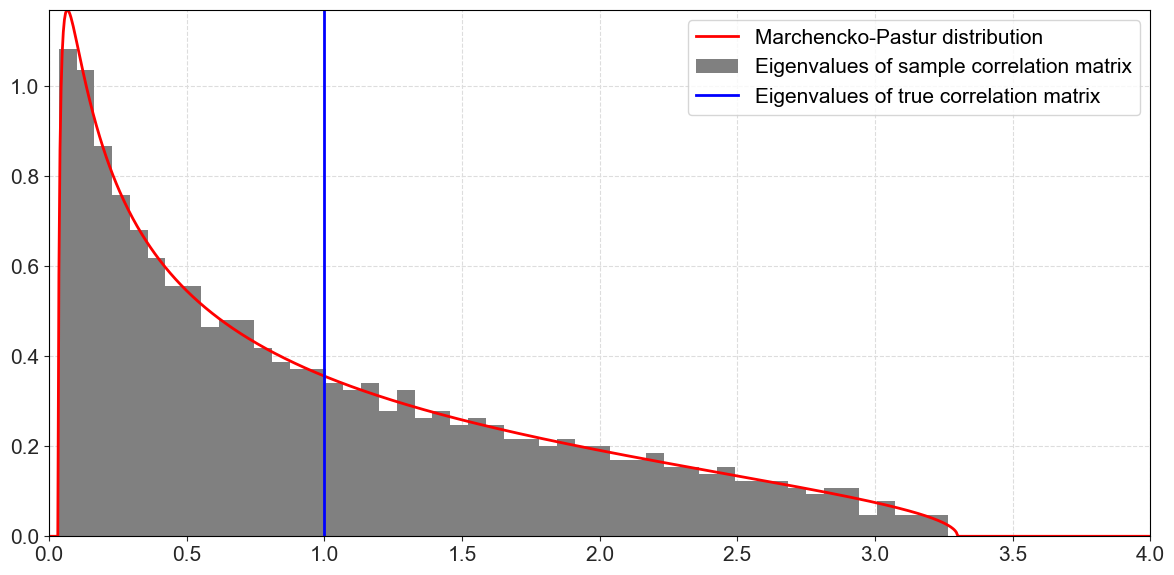

In [17]:
"""
Calculate covariance matrix (same as correlation matrix in this case) 
"""

corr_matrix = np.corrcoef(simulated_data.T)
eig_vals, eig_vectors = np.linalg.eig(corr_matrix)

"""
Plot the density of the eigenvalues
"""

x = np.linspace(0.0, 4.0, 1000)
dv = marchencko_pastur_density(x, 1.0,  n/t)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x, dv, color="red", label="Marchencko-Pastur distribution")
plt.hist(eig_vals, bins=50, color="gray", density=True, label="Eigenvalues of sample correlation matrix"); 
#plt.hist(true_eigenvalues[0], bins=1, color="blue", rwidth=0.05, density=True, label='Eigenvalues of true correlation matrix')
ax.axvline(1.0,color="blue", label='Eigenvalues of true correlation matrix')
plt.legend();

plt.tight_layout()

plt.savefig('marchencko_pastur_dist.pdf', dpi=300)